In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.field_names import FieldName
from gluonts.mx.trainer.callback import TrainingHistory

from gluonts.time_feature import (
    day_of_week,
    day_of_month,
    day_of_year,
    week_of_year,
    month_of_year,
)

from gluonts.time_feature.holiday import (
   squared_exponential_kernel,
   SpecialDateFeatureSet,
   CHRISTMAS_DAY,
   CHRISTMAS_EVE
)

#### Read dataset

In [8]:
EVdata = pd.read_csv("stationAggDaytoDay2011_2020May12.csv", header = 0, index_col = 0)

In [9]:
EVdata = EVdata[EVdata['StartDate'] < '2020-07-01']

In [10]:
EVdata.set_index('StartDate', inplace=True)

In [11]:
EVdata.head()

,Station Name,counts,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons)
StartDate,,,,,
2011-10-13,BRYANT 1,2,8.262052,3.470,1.037
2011-10-14,BRYANT 1,1,6.259466,2.629,0.786
2011-10-15,BRYANT 1,1,4.622894,1.942,0.580
2011-10-17,BRYANT 1,1,4.023361,1.690,0.505
2011-10-18,BRYANT 1,1,15.474944,6.499,1.942


##### TestData: one time series

In [12]:
testData= EVdata.loc[EVdata["Station Name"] == "HAMILTON 1", ["counts", "Energy (kWh)"]]

In [13]:
testData = testData.rename(columns = {"Energy (kWh)": "target"})

In [14]:
testData["item_id"] = "HAMILTON 1"

In [15]:
testData.head()

,counts,target,item_id
StartDate,,,
2011-07-29,1,6.249457,HAMILTON 1
2011-07-30,5,28.978653,HAMILTON 1
2011-07-31,3,37.209163,HAMILTON 1
2011-08-01,1,5.041244,HAMILTON 1
2011-08-02,1,4.197217,HAMILTON 1


In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
def one_or_multiple_time_series(data, station_name_list, target, item_id, fields):
    '''
    purpose: 
        1. select one or multiple time series
        2. change the column names

    input variables:
        data: input dataframe
        station_name_list: the station name list (each one is a time series)
        target: the target variable name
        item_id: id of each time series, here it means station name list
        fields: input fields from the input data
    '''
    testData= data.loc[EVdata["Station Name"] == station_name_list, fields]
    testData = testData.rename(columns = {target: "target"})
    testData["item_id"] = item_id
    return testData

In [18]:
def multiple_time_series(data, target, fields):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    testData = data.loc[:, fields]
    testData = testData.rename(columns = {target: "target"})
    testData['item_id'] = label_encoder.fit_transform(testData['Station Name'])
    station_name_map = testData[['Station Name', 'item_id']]
    testData.drop(columns = ['Station Name'], inplace = True)
    return testData, station_name_map

In [19]:
data = EVdata
station_name_list = "HAMILTON 1"
target = "Energy (kWh)"
item_id = "HAMILTON 1"
# fields = ["counts", "Energy (kWh)"]
fields = ["Station Name", "counts", "Energy (kWh)"]

# testData = one_or_multiple_time_series(EVdata, station_name_list, target, item_id, fields)
testData, station_name_map = multiple_time_series(EVdata, target, fields)
testData.head()


,counts,target,item_id
StartDate,,,
2011-10-13,2,8.262052,0
2011-10-14,1,6.259466,0
2011-10-15,1,4.622894,0
2011-10-17,1,4.023361,0
2011-10-18,1,15.474944,0


In [102]:
station_name_map = station_name_map.reset_index().drop(columns = ["StartDate"]).drop_duplicates().reset_index().drop(columns = ["index"])
print(station_name_map)

       Station Name  item_id
0          BRYANT 1        0
1          BRYANT 2        1
2          BRYANT 3        2
3          BRYANT 4        3
4          BRYANT 5        4
5          BRYANT 6        5
6       CAMBRIDGE 1        6
7       CAMBRIDGE 2        7
8       CAMBRIDGE 3        8
9       CAMBRIDGE 4        9
10      CAMBRIDGE 5       10
11       HAMILTON 1       11
12       HAMILTON 2       12
13           HIGH 1       13
14           HIGH 2       14
15           HIGH 3       15
16           HIGH 4       16
17            MPL 1       17
18            MPL 2       18
19            MPL 3       19
20            MPL 4       20
21            MPL 5       21
22            MPL 6       22
23  RINCONADA LIB 1       23
24  RINCONADA LIB 2       24
25  RINCONADA LIB 3       25
26   TED THOMPSON 1       26
27   TED THOMPSON 2       27
28   TED THOMPSON 3       28
29   TED THOMPSON 4       29
30        WEBSTER 1       30
31        WEBSTER 2       31
32        WEBSTER 3       32


#### Handle missing data

In [21]:
ds = PandasDataset.from_long_dataframe(testData, target="target", item_id="item_id", freq = "D")

In [22]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0
print(dfs_dict)

{0:             counts    target
2011-10-13     2.0  8.262052
2011-10-14     1.0  6.259466
2011-10-15     1.0  4.622894
2011-10-16     0.0  0.000000
2011-10-17     1.0  4.023361
...            ...       ...
2020-06-26     0.0  0.000000
2020-06-27     1.0  1.133000
2020-06-28     0.0  0.000000
2020-06-29     0.0  0.000000
2020-06-30     1.0  0.969000

[3184 rows x 2 columns], 1:             counts     target
2011-10-10     2.0  16.764479
2011-10-11     1.0  13.397377
2011-10-12     2.0  16.016336
2011-10-13     1.0  18.080227
2011-10-14     1.0   5.648643
...            ...        ...
2020-06-26     0.0   0.000000
2020-06-27     0.0   0.000000
2020-06-28     0.0   0.000000
2020-06-29     0.0   0.000000
2020-06-30     0.0   0.000000

[3187 rows x 2 columns], 2:             counts     target
2016-01-14     4.0  17.080252
2016-01-15     6.0  28.369562
2016-01-16     5.0  31.712811
2016-01-17     2.0   7.865278
2016-01-18     5.0  52.964527
...            ...        ...
2020-06-26     0.0  

In [23]:
ds = PandasDataset(dfs_dict, target="target")
counts = np.array([dfs_dict[item].loc[:, "counts"].to_numpy() for item in dfs_dict])
# counts = dfs_dict["HAMILTON 1"].loc[:, "counts"].to_numpy()

/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_46365/188289404.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  counts = np.array([dfs_dict[item].loc[:, "counts"].to_numpy() for item in dfs_dict])


#### Add multiple features

##### Number of counts

In [24]:
train_val_test_split = [0.7, 0.2, 0.1]
train_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[0])
validation_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[1])
prediction_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[2])

freq = "1D"
train_start = pd.Period('2011-07-29', freq = freq)

In [25]:
train_length, validation_length, prediction_length

(2228, 636, 318)

In [26]:
next(iter(ds))["target"].shape

(3184,)

In [27]:
next(iter(ds))["target"][: -prediction_length].shape

(2866,)

##### Temporal variables

In [28]:
holidat_set = SpecialDateFeatureSet([CHRISTMAS_EVE, CHRISTMAS_DAY])

In [29]:
data.head()

,Station Name,counts,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons)
StartDate,,,,,
2011-10-13,BRYANT 1,2,8.262052,3.470,1.037
2011-10-14,BRYANT 1,1,6.259466,2.629,0.786
2011-10-15,BRYANT 1,1,4.622894,1.942,0.580
2011-10-17,BRYANT 1,1,4.023361,1.690,0.505
2011-10-18,BRYANT 1,1,15.474944,6.499,1.942


In [30]:
start_date = data.index.min()
end_date = data.index.max()
start_date, end_date

('2011-07-29', '2020-06-30')

In [31]:
date_indices = pd.date_range(
    start = start_date,
    end = end_date,
    freq = 'D'
)

In [32]:
day_of_week_variable = np.array([day_of_week(date_indices) for item in ds])

day_of_month_variable = np.array([day_of_month(date_indices) for item in ds])
day_year_variable = np.array([day_of_year(date_indices) for item in ds])
week_of_year_variable = np.array([week_of_year(date_indices) for item in ds])
month_of_year_variable = np.array([month_of_year(date_indices) for item in ds])

In [33]:
len(day_of_week_variable[0])

3260

In [34]:
len(day_of_week_variable[0][:train_length])

2228

#### Use train and split

In [35]:
max_length = max(len(item['target']) for item in ds)
padded_targets = [np.pad(arr['target'], (max_length - len(arr['target']), 0), mode='constant') for arr in ds]
target = np.vstack(padded_targets)
# next(iter(ds))["target"][: train_length].reshape(1, next(iter(ds))["target"][: train_length].shape[0])

In [36]:
start = np.array([item['start'] for item in ds])

In [37]:
max_length = max(len(item) for item in counts)
padded_counts = [np.pad(arr, (max_length - len(arr), 0), mode='constant') for arr in counts]
counts = np.vstack(padded_counts)

In [38]:
target

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.969],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., 22.764,  9.425,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ..., 13.803, 18.608, 19.683],
       [ 0.   ,  0.   ,  0.   , ...,  5.935,  0.065, 58.624],
       [ 0.   ,  0.   ,  0.   , ...,  0.   , 27.877, 23.996]])

In [39]:
target.ndim

2

In [40]:
len(target[:, :train_length])

33

In [104]:
start_date_period = pd.Period(data.index.min(), freq='D')
start = [start_date_period for _ in range(len(target))]

In [42]:
freq

'1D'

In [43]:
len(target[:, :train_length][0])

2228

In [44]:
len(day_of_week_variable[:][:train_length][0])

3260

In [45]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target[:, :train_length],
            start,
            counts[:, :train_length],
            day_of_week_variable[:, :train_length],
            month_of_year_variable[:, :train_length]
        )
    ],
    freq=freq,
)

In [46]:
val_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target[:, :-prediction_length],
            start,
            counts[:, :-prediction_length],
            day_of_week_variable[:, :-prediction_length],
            month_of_year_variable[:, :-prediction_length]
        )
    ],
    freq=freq,
)

In [47]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target,
            start,
            counts,
            day_of_week_variable,
            month_of_year_variable
        )
    ],
    freq=freq,
)

In [48]:
def check_train_val_test_data(train_ds, val_ds, test_ds):
    print("training data: \n \t {} \n".format(train_ds))
    print("validation data: \n \t {} \n".format(val_ds))
    print("testing data: \n \t {} \n".format(test_ds))

In [49]:
check_train_val_test_data(train_ds, val_ds, test_ds)

training data: 
 	 [{'target': array([ 0.   ,  0.   ,  0.   , ..., 23.222, 58.488, 23.058], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[0.        , 0.        , 0.        , ..., 2.        , 4.        ,
        2.        ],
       [0.16666667, 0.33333334, 0.5       , ..., 0.        , 0.16666667,
        0.33333334],
       [0.04545455, 0.04545455, 0.04545455, ..., 0.13636364, 0.22727273,
        0.22727273]], dtype=float32)}, {'target': array([ 0.   ,  0.   ,  0.   , ..., 28.246, 25.99 ,  2.288], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[0.        , 0.        , 0.        , ..., 3.        , 4.        ,
        1.        ],
       [0.16666667, 0.33333334, 0.5       , ..., 0.        , 0.16666667,
        0.33333334],
       [0.04545455, 0.04545455, 0.04545455, ..., 0.13636364, 0.22727273,
        0.22727273]], dtype=float32)}, {'target': array([ 0.   ,  0.   ,  0.   , ..., 24.135, 33.996,  9.856], dtype=float32), 's

#### Visualize the dataset

In [105]:
def visualize_train_val_test_data(train_ds, val_ds, test_ds):
    train_entry = next(iter(train_ds))
    train_series = to_pandas(train_entry)
    
    val_entry = next(iter(val_ds))
    val_series = to_pandas(val_entry)

    test_entry = next(iter(test_ds))
    test_series = to_pandas(test_entry)

    plt.figure(figsize=(10, 6))
    
    test_series.plot(color = "grey")
    plt.axvline(train_series.index[-1], color="red")  # end of train dataset
    plt.axvline(val_series.index[-1], color="blue")  # end of train dataset
    plt.grid(which="both")
    plt.legend(["test series", "end of train series", "end of val series"], loc="upper left")
    plt.show()

    plt.savefig('train_val_test_data_vis.jpg')

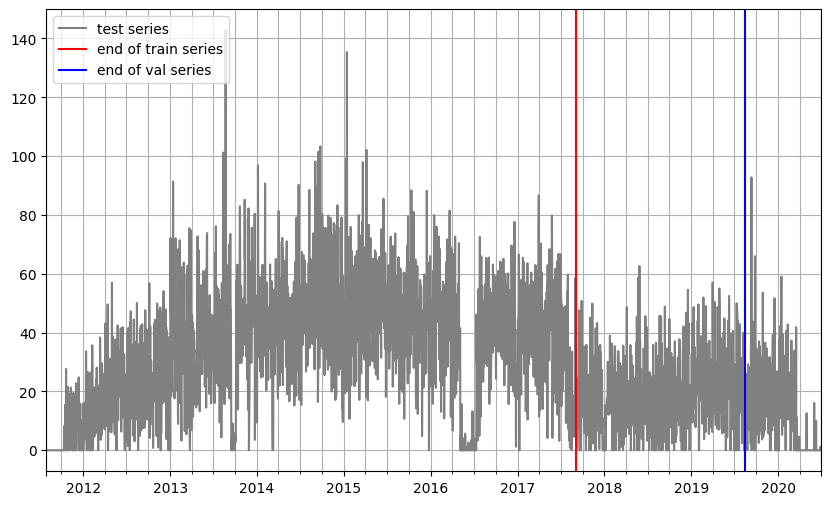

<Figure size 640x480 with 0 Axes>

In [106]:
visualize_train_val_test_data(train_ds, val_ds, test_ds)

#### Train and prediction

##### Simple feed forward estimator

In [52]:
# defining a callback, which will log the training loss for each epoch
history = TrainingHistory()

In [217]:
simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50], ## default: 50
    prediction_length=prediction_length,
    batch_normalization = False, ## default: false
    mean_scaling = True, ## default: true
    context_length=100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### MQCNN estimator

In [165]:
from gluonts.mx import MQCNNEstimator, Trainer

In [168]:
mqcnn_estimator = MQCNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### MQRNN estimator

In [169]:
from gluonts.mx import MQRNNEstimator, Trainer

In [170]:
mqrnn_estimator = MQRNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepAR estimator

In [171]:
from gluonts.mx import DeepAREstimator, Trainer

In [175]:
deepAR_estimator = DeepAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepVAR estimator

In [176]:
from gluonts.mx import DeepVAREstimator, Trainer

In [177]:
deepVAR_estimator = DeepVAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    dropout_rate=0.1,
    use_feat_dynamic_real=True,
    target_dim= 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### LSTNet

In [178]:
from gluonts.mx import LSTNetEstimator, Trainer

In [179]:
lstnet_estimator = LSTNetEstimator(
    num_series = 46,
    prediction_length = prediction_length,
    ar_window = 10,
    channels = 1,
    context_length = 20,
    skip_size = 1,
    dropout_rate=0.1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=2, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Temporal fusion transformer

In [180]:
from gluonts.mx import TemporalFusionTransformerEstimator, Trainer

In [181]:
tft_estimator = TemporalFusionTransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    hidden_dim = 20,
    dropout_rate=0.1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=2, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Transformer estimator

In [182]:
from gluonts.mx import TransformerEstimator, Trainer

In [183]:
transformer_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    context_length = 100,
    dropout_rate=0.1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Deepfactor estimator

In [184]:
from gluonts.mx import DeepFactorEstimator, Trainer

In [185]:
deepFactor_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### GP estimator

In [186]:
from gluonts.mx import GaussianProcessEstimator, Trainer

In [187]:
gp_estimator = GaussianProcessEstimator(
    freq = freq,
    prediction_length = prediction_length,
    cardinality = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Naive predictor

In [188]:
from gluonts.ext.naive_2 import Naive2Predictor

In [189]:
naive_predictor = Naive2Predictor(
    prediction_length = prediction_length,
    season_length = 100
)

##### Train and predict

In [190]:
def train_and_predict(train_dataset, val_dataset, test_dataset, estimator):
    predictor = estimator.train(training_data = train_dataset, validation_data = val_dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return predictor, list(forecast_it), list(ts_it)


In [191]:
def get_model_name(estimator):
    s = str(estimator)

    start_marker = ".model."
    end_marker = "._estimator"

    start_index = s.find(start_marker)
    if(start_index == -1):
        raise ValueError("Couldn't find start index!")

    end_index = s.find(end_marker, start_index)
    if(end_index == -1):
        return ValueError("Couldn't find end index!")
    
    start_index += len(start_marker)
    return s[start_index: end_index]

In [192]:
def multiple_models(train_ds, val_ds, test_ds, estimators, samples):
    predictors_all = []
    agg_metrics_all = []
    item_metrics_all = []
    forecast_it_all = []
    ts_it_all = []
    for estimator in estimators:
        
        ## model training
        predictor, forecast_it, ts_it = train_and_predict(train_ds, val_ds, test_ds, estimator)

        ## loss curve
        loss_data_framework = get_loss_curve(history)
        export_loss_curve(loss_data_framework, estimator)
        plot_loss_curve(loss_data_framework, estimator)

        ## evluation metrics
        print_forecast_basic_info(forecast_it, ts_it)
        export_original_time_series_no_missing_values(ts_it)
        export_predicted_values(ts_it, forecast_it, estimator)
        plot_orginal_prediction(forecast_it, ts_it, estimator, samples)
        agg_metrics, item_metrics = get_evaluation_metrics(forecast_it, ts_it)
        export_eval_metrics(agg_metrics, item_metrics, estimator)

        predictors_all.append(predictor)
        agg_metrics_all.append(agg_metrics)
        item_metrics_all.append(item_metrics)
        forecast_it_all.append(forecast_it)
        ts_it_all.append(ts_it)

        return predictors_all, agg_metrics_all, item_metrics_all, forecast_it_all, ts_it_all
    

In [193]:
def get_loss_curve(history):
    loss_data_framework = pd.DataFrame({
        "training_loss": history.loss_history,
        "val_loss": history.validation_loss_history
    })
    loss_data_framework.head()
    return loss_data_framework

In [194]:
def export_loss_curve(loss_data_framework, estimator):
    loss_curve_name = "loss_curve_model_{}.csv".format(get_model_name(estimator))
    loss_data_framework.to_csv(loss_curve_name)

In [216]:
def plot_loss_curve(loss_data_framework, estimator):
    # Clear the current figure
    plt.clf()

    loss_data_framework["epochs"] = range(1, len(loss_data_framework) + 1)

    plt.plot(loss_data_framework["epochs"], loss_data_framework["training_loss"], 'o-', label='Training Loss', color='blue', linestyle='--')
    plt.plot(loss_data_framework["epochs"], loss_data_framework["val_loss"], 's-', label='Validation Loss', color='red', linestyle='-.')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig(f'{get_model_name(estimator)}_train_val_loss.jpg')

In [208]:
def print_forecast_basic_info(forecast_it, ts_it):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]

    print(f"Number of sample paths: {forecast_entry.num_samples}")
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

In [209]:
def export_original_time_series_no_missing_values(ts_it):

    ts_entry = ts_it[0]
    
    time_series_original = pd.DataFrame(ts_entry)
    time_series_original.columns = ['true_value']
    time_series_original.to_csv("time_series_original_no_missing_values.csv")

In [210]:
def export_predicted_values(ts_it, forecast_it, estimator):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]
    
    predicted_values = "predicted_values_model_{}.csv".format(get_model_name(estimator))
    predicted_values_100_series = pd.DataFrame(forecast_entry.samples.T)
    predicted_values_100_series.to_csv(predicted_values)

In [211]:
def plot_orginal_prediction(forecast_it, ts_it, estimator, samples):
    # Clear the current figure
    plt.figure(figsize=[10, 6])
    
    for i in samples:
        plt.clf()
        forecast_entry = forecast_it[i]
        ts_entry = ts_it[i]

        plt.plot(ts_entry[-800:].to_timestamp())
        forecast_entry.plot(show_label=True)
        plt.legend()
        plt.savefig("testing_{}{}.png".format(get_model_name(estimator), i))

In [212]:
def get_evaluation_metrics(forecast_it, ts_it):

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it)

    return agg_metrics, item_metrics

In [213]:
def export_eval_metrics(agg_metrics, item_metrics, estimator):
    ## agg_metrics
    print("Evaluation metrics: {}".format(get_model_name(estimator)))
    agg_metrics_data_frame = pd.DataFrame([agg_metrics])

    agg_metrics_csv_name = "agg_metrics_{}.csv".format(get_model_name(estimator))

    item_metrics_csv_name = "item_metrics_{}.csv".format(get_model_name(estimator))

    agg_metrics_data_frame.to_csv(agg_metrics_csv_name)
    item_metrics.to_csv(item_metrics_csv_name)

In [214]:
def map_station_name_index(station_samples):
    station_name_index = station_name_map[station_name_map["Station Name"].isin(station_samples)]
    samples_index = station_name_index['item_id'].tolist()
    return samples_index

100%|██████████| 100/100 [00:01<00:00, 52.99it/s, epoch=1/20, avg_epoch_loss=3.43]
2it [00:00, 122.38it/s, epoch=1/20, validation_avg_epoch_loss=4.63]
100%|██████████| 100/100 [00:01<00:00, 58.26it/s, epoch=2/20, avg_epoch_loss=2.3]
2it [00:00, 191.09it/s, epoch=2/20, validation_avg_epoch_loss=4.72]
100%|██████████| 100/100 [00:01<00:00, 57.26it/s, epoch=3/20, avg_epoch_loss=0.97]
2it [00:00, 130.11it/s, epoch=3/20, validation_avg_epoch_loss=4.81]
100%|██████████| 100/100 [00:01<00:00, 53.86it/s, epoch=4/20, avg_epoch_loss=0.677]
2it [00:00, 134.72it/s, epoch=4/20, validation_avg_epoch_loss=4.74]
100%|██████████| 100/100 [00:01<00:00, 56.84it/s, epoch=5/20, avg_epoch_loss=0.654]
2it [00:00, 165.43it/s, epoch=5/20, validation_avg_epoch_loss=4.93]
100%|██████████| 100/100 [00:01<00:00, 52.84it/s, epoch=6/20, avg_epoch_loss=0.515]
2it [00:00, 147.04it/s, epoch=6/20, validation_avg_epoch_loss=4.79]
100%|██████████| 100/100 [00:01<00:00, 52.77it/s, epoch=7/20, avg_epoch_loss=0.302]
2it [00:

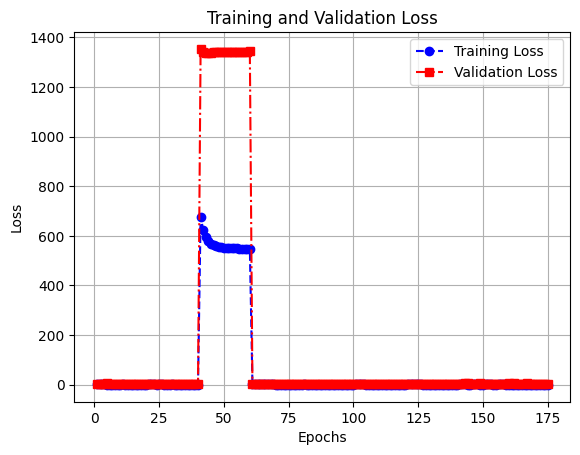

Number of sample paths: 100
Dimension of samples: (100, 318)
Start date of the forecast window: 2019-08-18
Frequency of the time series: <Day>


Running evaluation: 33it [00:00, 101.61it/s]


Evaluation metrics: simple_feedforward


<Figure size 640x480 with 0 Axes>

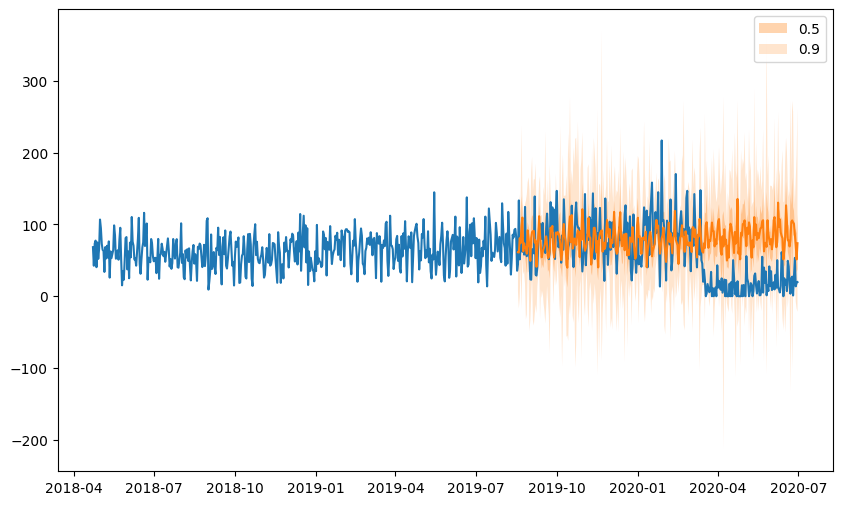

In [218]:
## Available estmators: 
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## lstnet_estimator: LSTnet
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN

# estimators = [simple_feed_forward_estimator, \
#               deepAR_estimator, \
#               deepVAR_estimator, \
#               lstNetEstimator, \
#               transformer_estimator, \
#               mqcnn_estimator]

estimators = [simple_feed_forward_estimator]
model_metrics = {}

## name of sample stations you'd like to plot
station_samples = ["WEBSTER 1", "MPL 5", "RINCONADA LIB 1", "BRYANT 4"]
samples_index = map_station_name_index(station_samples)

predictor, agg_metrics, item_metrics, forecast_it, ts_it = multiple_models(train_ds, val_ds, test_ds, estimators, samples_index)

#### Model selection

In [ ]:
weights = {
    'MSE': 0.4,
    'MAE': 0.3,
    'RMSE': 0.2,
    'MSIS': 0.1
}

# agg_metrics, item_metrics

estimators = [simple_feed_forward_estimator]

for index, value in enumerate(estimators):
    combined_score = sum(weights[metric] * agg_metrics[metric] for metric in weights)
    print(combined_score)

#### Fine tuning

In [219]:
import optuna
import torch
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
from gluonts.torch.model.deepar import DeepAREstimator

In [220]:
def dataentry_to_dataframe(entry):
    df = pd.DataFrame(
        entry["target"],
        columns=[entry.get("item_id")],
        index=pd.period_range(
            start=entry["start"], periods=len(entry["target"]), freq=entry["start"].freq
        ),
    )

    return df

In [ ]:
class DeepARTuningObjective:
    def __init__(
        self, dataset, prediction_length, freq, metric_type="mean_wQuantileLoss"
    ):
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type

        self.train, test_template = split(dataset, offset=-self.prediction_length)
        validation = test_template.generate_instances(
            prediction_length=prediction_length
        )
        self.validation_input = [entry[0] for entry in validation]
        self.validation_label = [
            dataentry_to_dataframe(entry[1]) for entry in validation
        ]

    def get_params(self, trial) -> dict:
        return {
            "num_layers": trial.suggest_int("num_layers", 1, 5),
            "hidden_size": trial.suggest_int("hidden_size", 10, 50),
            "batch_size": trial.suggest_int("batch_size", 30, 100),
            "learning_rate": trial.suggest_int("learning_rate", 0.001, 0.1)
        }

    def __call__(self, trial):
        params = self.get_params(trial)
        estimator = DeepAREstimator(
            num_layers=params["num_layers"],
            hidden_size=params["hidden_size"],
            prediction_length=self.prediction_length,
            freq=self.freq,
            trainer_kwargs={
                "enable_progress_bar": False,
                "enable_model_summary": False,
                "max_epochs": 5,
            },
        )

        predictor = estimator.train(self.train, cache_data=True)
        forecast_it = predictor.predict(self.validation_input)

        forecasts = list(forecast_it)

        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evaluator(
            self.validation_label, forecasts, num_series=len(self.dataset)
        )
        return agg_metrics[self.metric_type]

In [222]:
import time

start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(
    DeepARTuningObjective(
        val_ds, validation_length, freq
    ),
    n_trials=5,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
print(time.time() - start_time)

[I 2024-08-24 11:22:59,354] A new study created in memory with name: no-name-d177c2a5-d025-4821-bf83-57d08da94d2a
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
2024-08-24 11:23:07.115294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 0, global step 50: 'train_loss' reached -10.34214 (best -10.34214), saving model to '/Users/tuyuanjie/Documents/EV_charging_demand_prediction_project/time_series_modeling/lightning_logs/version_5/checkpo

### Re-training the model

In [ ]:
estimator = DeepAREstimator(
    num_layers=trial.params["num_layers"],
    hidden_size=trial.params["hidden_size"],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer_kwargs={
        "enable_progress_bar": False,
        "enable_model_summary": False,
        "max_epochs": 10,
    },
)

In [ ]:
predictor = estimator.train(training_data = train_ds, validation_data = val_dataset, cache_data=True)

In [ ]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
plt.figure(figsize = [10, 6])
plt.plot(tss[0][-150:].to_timestamp())
forecasts[0].plot(show_label=True)
plt.legend()

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

In [ ]:
print(json.dumps(agg_metrics, indent=4))

In [ ]:
item_metrics.head()

In [ ]:
item_metrics.plot(x="sMAPE", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

### Save existing model

In [ ]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))